### Finding the overlap between novel UTRons and microRNA sites predicted from TargetScan

Statement to find overlap: 

bedtools intersect 
    -c
    -a novel_utrons.bed
    -b TS_predictions_hg38_liftover.bed
    > overlap.txt
    
File in misc_files microRNAoverlap.txt has the number of overlaps with microRNAs for these genes
   (done for both novel and known)

In [41]:
import pandas as pd
import sqlite3
import pandas as pd
import numpy as np

cnx = sqlite3.connect('/shared/sudlab1/General/projects/utrons_project/BladderCancerUtrons/431BladderUtrons.db')
cnx.execute("ATTACH '/shared/sudlab1/General/annotations/hg38_noalt_ensembl85/csvdb' as annotations")

systematicUtrons = "/shared/sudlab1/General/projects/utrons_project/misc_files/systematicUtronGenes.txt"
systematicUtrons = pd.read_csv(systematicUtrons, sep="\t", header=None)

In [33]:
novelOverlapFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/microRNAOverlap.txt"
allOverlapFile = "/shared/sudlab1/General/projects/utrons_project/misc_files/allUtronsMicroRnaOverlap.txt"

novelOverlap = pd.read_csv(novelOverlapFile, sep=" |\t", engine="python", header=None)
allOverlap = pd.read_csv(allOverlapFile, sep=" |\t", engine="python", header=None)

def getId(row):
    Id = row[3][:-16]
    return Id

novelOverlap["GeneId"] = novelOverlap.apply(getId, axis=1)
allOverlap["GeneId"] = allOverlap[3]

novelOverlap = novelOverlap[["GeneId", 7]]
allOverlap = allOverlap[["GeneId", 12]]

In [43]:
query_text1 = '''
    SELECT uid.transcript_id AS Name, ti.gene_name AS Gene
    FROM novel_utrons_ids AS uid
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = uid.match_transcript_id
    WHERE uid.track='agg-agg-agg' AND uid.transcript_id like "MSTRG%"
    ORDER BY uid.transcript_id
    '''
novelIds = pd.read_sql_query(query_text1, cnx)
novelIds = novelIds[~novelIds["Gene"].isin(systematicUtrons[0])]


query_text1 = '''
    SELECT uid.transcript_id AS Name, ti.gene_name AS Gene
    FROM all_utrons_ids AS uid
    INNER JOIN transcript_class AS tc
    ON tc.transcript_id = uid.transcript_id
    INNER JOIN annotations.transcript_info AS ti
    ON ti.transcript_id = tc.match_transcript_id 
    WHERE uid.track='agg-agg-agg' AND uid.transcript_id like "ENS%"
    ORDER BY uid.transcript_id
    '''
knownIds = pd.read_sql_query(query_text1, cnx)
knownIds = knownIds[~knownIds["Gene"].isin(systematicUtrons[0])]

In [56]:
novelOverlap = novelOverlap[novelOverlap["GeneId"].isin(novelIds["Name"])]
allOverlap = allOverlap[allOverlap["GeneId"].isin(knownIds["Name"])]


print len(novelOverlap[novelOverlap[7]>0]), len(novelOverlap[novelOverlap[7]==0])
print len(allOverlap[allOverlap[12]>0]), len(allOverlap[allOverlap[12]==0])

424 3068
1199 26449


Populating the interactive namespace from numpy and matplotlib


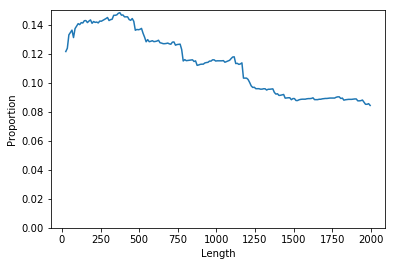

In [166]:
lengthInfo = pd.read_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/SpliceSite/novelLengths.txt", sep="\t")

def getPercents(length):
    shortIds = lengthInfo[lengthInfo["Length"]<=length]["transcript_id"]

    shortNovel = novelOverlap[novelOverlap["GeneId"].isin(shortIds)]
    longNovel = novelOverlap[~novelOverlap["GeneId"].isin(shortIds)]

    shortWith = len(shortNovel[shortNovel[7]>0])
    shortNone = len(shortNovel[shortNovel[7]==0])
    longWith = len(longNovel[longNovel[7]>0])
    longNone = len(longNovel[longNovel[7]==0])
    
    percent1 = shortWith / float(shortWith + shortNone)
    percent2 = longWith / float(longWith + longNone)
    
    #print percent1 * 100, (1 - percent1) * 100
    #print percent2 * 100, (1 - percent2) * 100
    
    return percent1, percent2
    

%pylab inline

shortList = []
longList = []
lengthList = []
for num in range(25,2000,10):
    a, b = getPercents(num)
    shortList.append(a)
    longList.append(b)
    lengthList.append(num)

pylab.plot(lengthList, longList)
pylab.ylim(0,0.15)
pylab.xlabel("Length")
pylab.ylabel("Proportion")
pylab.savefig("./images/LengthVsMicroRNA", dpi=300)


In [108]:
print longList

[0.12158808933002481, 0.12386156648451731, 0.13311421528348397, 0.13479052823315119, 0.13636363636363635, 0.1312240663900415, 0.13743815283122596, 0.13908450704225353, 0.14081885856079404, 0.14018087855297157, 0.1415282392026578, 0.1412894375857339, 0.14285714285714285, 0.14296134208606856, 0.14157303370786517, 0.1426403641881639, 0.14340786430223593, 0.1410756040530008, 0.1422924901185771, 0.14170692431561996, 0.14193025141930252, 0.14133986928104575, 0.14262159934047816, 0.14250207125103562, 0.14309623430962343, 0.14370748299319727, 0.14432989690721648, 0.14507772020725387, 0.14298169136878813, 0.1436077057793345, 0.14386584289496912, 0.14658273381294964, 0.14660633484162897, 0.1468721668177697, 0.1479779411764706, 0.14838709677419354, 0.1467038068709378, 0.14684014869888476, 0.1455223880597015, 0.1455223880597015, 0.14553990610328638, 0.14366729678638943, 0.14312796208530806, 0.14435946462715105, 0.1424446583253128, 0.13627450980392156, 0.13681102362204725, 0.13663366336633664, 0.13

In [131]:
tpm = 20
supDf = pd.read_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/suppresor_%dTPM.txt" % tpm,sep="\t", header=None)
oncDf = pd.read_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/oncogenes_%dTPM.txt" % tpm,sep="\t", header=None)
unkDf = pd.read_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/unknown_%dTPM.txt" % tpm,sep="\t", header=None)

In [134]:
allOncOverlap = allOverlap[allOverlap["GeneId"].isin(oncDf[0])]
novelOncOverlap = novelOverlap[novelOverlap["GeneId"].isin(oncDf[0])]

print "oncogenes"
print "known", len(allOncOverlap[allOncOverlap[12]>0])/ float(len(allOncOverlap))
print "novel", len(novelOncOverlap[novelOncOverlap[7]>0])/float(len(novelOncOverlap))


allSupOverlap = allOverlap[allOverlap["GeneId"].isin(supDf[0])]
novelSupOverlap = novelOverlap[novelOverlap["GeneId"].isin(supDf[0])]

print "\nSuppressors"
print "known", len(allSupOverlap[allSupOverlap[12]>0])/ float(len(allSupOverlap))
print "novel", len(novelSupOverlap[novelSupOverlap[7]>0])/float(len(novelSupOverlap))


allUnkOverlap = allOverlap[allOverlap["GeneId"].isin(unkDf[0])]
novelUnkOverlap = novelOverlap[novelOverlap["GeneId"].isin(unkDf[0])]

print "\nUnknown"
print "known", len(allUnkOverlap[allUnkOverlap[12]>0])/ float(len(allSupOverlap))
print "novel", len(novelUnkOverlap[novelUnkOverlap[7]>0])/float(len(novelSupOverlap))


oncogenes
known 0.0953757225434
novel 0.311111111111

Suppressors
known 0.0454545454545
novel 0.125

Unknown
known 0.0833333333333
novel 0.0


In [168]:
oncGenes1 = pd.merge(knownIds, allOncOverlap, left_on="Name", right_on="GeneId")
print "Known Oncogenes removing microRNAs"
print sorted(oncGenes1["Gene"].unique())


oncGenes2 = pd.merge(novelIds, novelOncOverlap, left_on="Name", right_on="GeneId")
print "\n\nNovel Oncogenes removing microRNAs"
print sorted(oncGenes2["Gene"].unique())

Known Oncogenes removing microRNAs
[u'ACSL3', u'ADAM10', u'AKT1', u'AKT2', u'ALDH2', u'ASPSCR1', u'ATF1', u'ATIC', u'BCL11A', u'BCLAF1', u'BCR', u'BRAF', u'BRD4', u'CALR', u'CAMTA1', u'CANT1', u'CARM1', u'CARS', u'CCNB1IP1', u'CD74', u'CDK4', u'CHCHD7', u'CIITA', u'CLTC', u'CLTCL1', u'CMC4', u'COX6C', u'CREB3L2', u'CTNNB1', u'CTTN', u'DDX6', u'DEK', u'EIF4A2', u'ELN', u'ERBB2', u'ETV5', u'FGFR1', u'FIP1L1', u'GNAS', u'GOT2', u'HERPUD1', u'HNRNPA2B1', u'HOXA9', u'HRAS', u'HSP90AA1', u'IDH2', u'IL7R', u'KEAP1', u'KIF5B', u'KLK2', u'KRAS', u'KTN1', u'LASP1', u'LMO2', u'LZTR1', u'MDM2', u'MED17', u'METTL14', u'MLF1', u'MMP2', u'MUC1', u'MYH11', u'NACA', u'NDRG1', u'NIN', u'NRAS', u'NUMA1', u'NUP214', u'PAX8', u'PBX1', u'PCSK7', u'PDE4DIP', u'PDGFB', u'PICALM', u'PLCG1', u'PML', u'PPARG', u'PPP2R1A', u'PTPN11', u'RAF1', u'RHEB', u'RHOA', u'RPN1', u'SEPT5', u'SEPT9', u'SETDB1', u'SF3B1', u'SFPQ', u'SMC1A', u'SMO', u'SRSF2', u'SRSF3', u'SS18', u'SS18L1', u'SSX1', u'SSX2', u'SSX4', u'STAT3', u

In [169]:
supGenes1 = pd.merge(knownIds, allSupOverlap, left_on="Name", right_on="GeneId")
print "Known suppressors removing microRNAs"
print sorted(supGenes1["Gene"].unique())


supGenes2 = pd.merge(novelIds, novelSupOverlap, left_on="Name", right_on="GeneId")
print "\n\nNovel suppressors removing microRNAs"
print sorted(supGenes2["Gene"].unique())

Known suppressors removing microRNAs
[u'ASXL1', u'ATRX', u'B2M', u'BAP1', u'BMPR1A', u'CASP8', u'CAST', u'CBLC', u'CCAR1', u'CDH1', u'CDK12', u'CDKN1B', u'CDKN2A', u'CIC', u'CYLD', u'DDB2', u'EPHB6', u'ERCC3', u'EXT1', u'FANCA', u'FANCG', u'FAS', u'FBXO11', u'FUBP1', u'HLA-B', u'KDM5C', u'MAP2K4', u'MLH1', u'MSH6', u'MUTYH', u'NF1', u'NF2', u'PALB2', u'PIK3R1', u'RB1', u'RECQL4', u'SBDS', u'SDHC', u'SDHD', u'SMAD4', u'STK11', u'TBL1XR1', u'TOM1', u'TP53BP1', u'TSC2', u'XPC']


Novel suppressors removing microRNAs
[u'B2M', u'CDH1', u'CDKN1A', u'EXT1', u'PIK3R1', u'SDHC', u'ZFP36L2']


In [157]:
print "\t\tTranscripts", "\tGenes"
print "known Oncogenes \t %s \t %s" % (len(oncGenes1), len(oncGenes1["Gene"].unique()))
print "novel Oncogenes \t %s \t %s" % (len(oncGenes2), len(oncGenes2["Gene"].unique()))
print "known suppressors \t %s \t %s" % ( len(supGenes1), len(supGenes1["Gene"].unique()))
print "novel suppressors \t %s \t %s"% ( len(supGenes2), len(supGenes2["Gene"].unique()))

		Transcripts 	Genes
known Oncogenes 	 692 	 115
novel Oncogenes 	 59 	 22
known suppressors 	 264 	 46
novel suppressors 	 34 	 7


In [165]:
supjoined = pd.concat([supGenes1, supGenes2])
supjoined.to_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/suppressorMicroRNA.txt", sep="\t", header=None, index=None)

oncjoined = pd.concat([oncGenes1, oncGenes2])
oncjoined.to_csv("/shared/sudlab1/General/projects/utrons_project/misc_files/cancerUtrons/oncogeneMicroRNA.txt", sep="\t", header=None, index=None)